In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [28]:
stocks = input("Enter the ticket symbol (e.g. AAPL or RELIANCE.NS): ").strip().upper()
data = yf.download(stocks, "2020-01-01", "2025-09-18", auto_adjust=True)

Enter the ticket symbol (e.g. AAPL or RELIANCE.NS):  SI=F


[*********************100%***********************]  1 of 1 completed


In [29]:
print("Data shape:", data.shape)
print(data.head())
print(data.describe())

Data shape: (1437, 5)
Price           Close       High        Low       Open Volume
Ticker           SI=F       SI=F       SI=F       SI=F   SI=F
Date                                                         
2020-01-02  17.966000  17.990000  17.966000  17.966000      2
2020-01-03  18.068001  18.110001  17.965000  18.110001     83
2020-01-06  18.097000  18.105000  18.025000  18.025000      3
2020-01-07  18.316000  18.344999  18.014999  18.014999     33
2020-01-08  18.087999  18.504999  18.070000  18.400000     31
Price         Close         High          Low         Open         Volume
Ticker         SI=F         SI=F         SI=F         SI=F           SI=F
count   1437.000000  1437.000000  1437.000000  1437.000000    1437.000000
mean      25.203966    25.394686    25.022586    25.211383    1454.044537
std        5.254773     5.276725     5.223392     5.246739    8567.364316
min       11.735000    12.205000    11.735000    12.070000       0.000000
25%       22.430000    22.565001    22

In [30]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F
count,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,25.203966,25.394686,25.022586,25.211383,1454.044537
std,5.254773,5.276725,5.223392,5.246739,8567.364316
min,11.735000,12.205000,11.735000,12.070000,0.000000
25%,22.430000,22.565001,22.299999,22.455000,13.000000
50%,24.297001,24.429001,24.184999,24.313000,52.000000
75%,27.917000,28.100000,27.705000,27.895000,176.000000
max,42.516998,42.580002,42.435001,42.471001,131415.000000


<Figure size 1000x600 with 0 Axes>

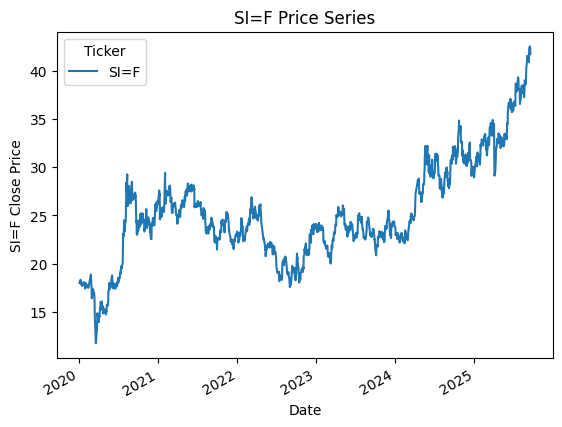

In [31]:
plt.figure(figsize=(10,6))
data['Close'].plot()
plt.ylabel(f"{stocks} Close Price")
plt.title(f"{stocks} Price Series")
plt.show()

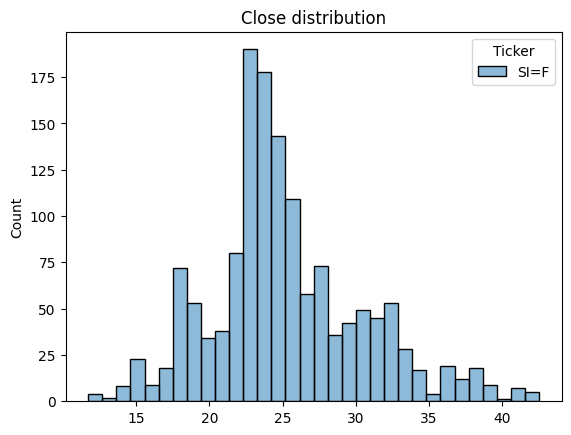

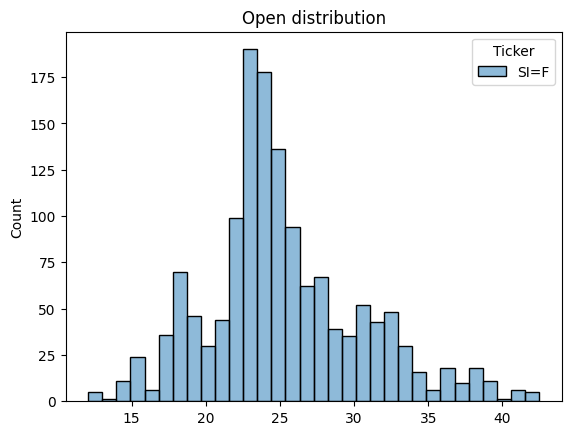

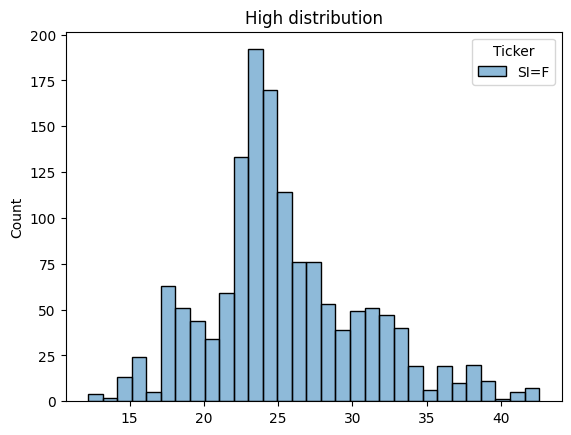

In [32]:
plt.figure(); sns.histplot(data["Close"]); plt.title("Close distribution"); plt.show()
plt.figure(); sns.histplot(data["Open"]); plt.title("Open distribution"); plt.show()
plt.figure(); sns.histplot(data["High"]); plt.title("High distribution"); plt.show()

In [33]:
numeric = data.select_dtypes(include=[np.number])
if 'Close' not in numeric.columns:
    raise KeyError("Close column missing in numeric columns after download/adjust.")
X = numeric.drop(columns = ['Close'])
Y = numeric['Close']

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("Train shapes:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)

Train shapes: (1149, 4) (1149, 1)
Test shape: (288, 4) (288, 1)


In [35]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_pred = lr.predict(X_test)
def calculate_metrics(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_true, Y_pred)
    return {'mse': mse, 'rmse': rmse, 'r2':r2}
print("Linear Regression metrics:", calculate_metrics(Y_test, lr_pred))

Linear Regression metrics: {'mse': 0.016558175291339246, 'rmse': np.float64(0.12867857355185147), 'r2': 0.999429293371064}


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
param_grid = {'C' : [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']}
grid = GridSearchCV(SVR(), param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, Y_train)
print("Best params:", grid.best_params_, "Best CV score:", grid.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'} Best CV score: 0.9988741807087123


C:\Users\thanu\cv_env\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
Y_test

Ticker,SI=F
Date,
2020-03-18,11.735000
2020-02-21,18.521000
2023-12-04,24.555000
2025-04-23,33.518002
2022-01-20,24.711000
...,...
2024-06-25,28.837000
2024-04-03,26.945000
2023-08-22,23.420000


In [39]:
best_svr = grid.best_estimator_
svr_pred = best_svr.predict(X_test_scaled)
print("SVR matrics:", calculate_metrics(Y_test, svr_pred))

SVR matrics: {'mse': 0.018332810980358438, 'rmse': np.float64(0.13539871114733124), 'r2': 0.9993681274313484}


In [40]:
joblib.dump({'model': best_svr, 'scaler': scaler}, 'svr_model_and_scaler.pkl')
print("Saved model to 'svr_model_and_scaler.pkl'")

Saved model to 'svr_model_and_scaler.pkl'
